In [25]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt 
plt.rc("font", size=14)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

In [26]:
df = pd.read_csv("data/flights_cleaned_no_outlier_iqr_with_delays.csv")

In [27]:
working = [ # ran with what the test data can do
    #'fl_date', # get month and bin
#     'op_unique_carrier', # most extensive name list
#     'origin', # need 'origin' to merge weather but already merged! ;)
#     'dest_airport_id', # not sure about this one
    'crs_dep_time', # bin times
#     'dep_time', # only using in TRAIN, to learn how other columns affect this
#     'crs_arr_time',
#     'arr_time', # only using in TRAIN, to learn how other columns affect this
    'weather_type', # add weight values
     'passengers', # not sure about this one
    'arr_delay' # so we can make a target column...
]

In [28]:
df_ = df.filter(items = working)

In [29]:
df_

,crs_dep_time,weather_type,passengers,arr_delay
0,543,Rainy,85523.0,-18.0
1,1328,Rainy,85523.0,-1.0
2,1449,Rainy,85523.0,-15.0
3,1301,Rainy,85523.0,-24.0
4,1001,Rainy,85523.0,-15.0
...,...,...,...,...
2073110,1835,Sunny,10465.0,-10.0
2073111,1039,Sunny,10465.0,-30.0
2073112,1353,Rainy,14422.0,-11.0
2073113,1955,Rainy,14422.0,-19.0


In [30]:
tcriteria = [df_['arr_delay'].between(-10000, 0.00001), df_['arr_delay'].between(0.00001, 10000)]

values = [0,1]

df_['arr_delay'] = np.select(tcriteria, values, 0)

In [31]:
tcriteria = [df_['passengers'].between(0, 10000), 
            df_['passengers'].between(10000, 30000),
             df_['passengers'].between(30000, 50000),
             df_['passengers'].between(50000, 70000),
             df_['passengers'].between(70000, 10000000)]

values = [1,2,3,4,5]

df_['passengers'] = np.select(tcriteria, values, 0)

In [58]:
df_.arr_delay.value_counts()

0    1681278
1     391837
Name: arr_delay, dtype: int64

In [33]:
df_ = pd.get_dummies(df_, columns=['weather_type'], drop_first=True)

In [34]:
df_ = pd.get_dummies(df_, columns=['passengers'], drop_first=True)

In [35]:
df_.crs_dep_time = df_.crs_dep_time // 100
crs_dep_time_remap = {
    0: 0.10,
    1: 0.10, 
    2: 0.10,
    3: 0.10, 
    4: 0.10,
    5: 0.10, 
    6: 1,
    7: 1, 
    8: 1,
    9: 1, 
    10: 1,
    11: 1, 
    12: 1,
    13: 1, 
    14: 1,
    15: 1, 
    16: 1,
    17: 1,
    18: 1,
    19: 1, 
    20: 1,
    21: 0.50, 
    22: 0.50, 
    23: 0.50
}
df_["dep_time_hour_weight"] = df_.crs_dep_time.map(crs_dep_time_remap)

In [41]:
X = df_.loc[:, df_.columns != 'arr_delay']
y = df_.loc[:, df_.columns == 'arr_delay']
from imblearn.over_sampling import SMOTE 
os = SMOTE(random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
columns = X_train.columns

os_data_X, os_data_y=os.fit_sample(X_train, y_train)

os_data_X = pd.DataFrame(data=os_data_X,columns=columns)
os_data_y = pd.DataFrame(data=os_data_y,columns=['arr_delay'])

# we can Check the numbers of our data
print("length of oversampled data is ",len(os_data_X))
print("Number of no subscription in oversampled data",len(os_data_y[os_data_y['arr_delay']==0]))
print("Number of subscription",len(os_data_y[os_data_y['arr_delay']==1]))
print("Proportion of no subscription data in oversampled data is ",len(os_data_y[os_data_y['arr_delay']==0])/len(os_data_X))
print("Proportion of subscription data in oversampled data is ",len(os_data_y[os_data_y['arr_delay']==1])/len(os_data_X))

length of oversampled data is  2353666
Number of no subscription in oversampled data 1176833
Number of subscription 1176833
Proportion of no subscription data in oversampled data is  0.5
Proportion of subscription data in oversampled data is  0.5


In [43]:
import statsmodels.api as sm
logit_model=sm.Logit(y,X)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.485912
         Iterations 6
                            Results: Logit
Model:               Logit             Pseudo R-squared:  -0.002      
Dependent Variable:  arr_delay         AIC:               2014723.5335
Date:                2021-10-22 10:52  BIC:               2014848.9791
No. Observations:    2073115           Log-Likelihood:    -1.0074e+06 
Df Model:            9                 LL-Null:           -1.0050e+06 
Df Residuals:        2073105           LLR p-value:       1.0000      
Converged:           1.0000            Scale:             1.0000      
No. Iterations:      6.0000                                           
----------------------------------------------------------------------
                      Coef.  Std.Err.     z     P>|z|   [0.025  0.975]
----------------------------------------------------------------------
crs_dep_time         -0.0180   0.0003  -55.3160 0.0000 -0.0187 -0.0174
wea

In [48]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
logreg = LogisticRegression()
logreg.fit(X_train, y_train.values.ravel())

LogisticRegression()

In [49]:
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.81


In [50]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[504445      0]
 [117490      0]]


In [51]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

/Users/nickmech/opt/anaconda3/envs/test/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.81      1.00      0.90    504445
           1       0.00      0.00      0.00    117490

    accuracy                           0.81    621935
   macro avg       0.41      0.50      0.45    621935
weighted avg       0.66      0.81      0.73    621935



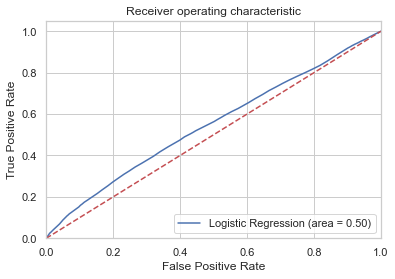

In [52]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

No delay seems to be predictable. 